## Import packages

In [1]:
# import uproot
import pyjet
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from os.path import isfile, isdir, join
import importlib
import time
import re
from tqdm import tqdm


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


Oranges = cm.get_cmap('Oranges_r', 256)
newcolors = Oranges(np.linspace(1, 0, 256))
white = np.array([256/256, 256/256, 256/256, 1])
newcolors[:1, :] = white
newcmap = ListedColormap(newcolors, name='OrangeWhite')

%config InlineBackend. figure_format = 'retina'

In [2]:
def Loading_Data(data_source, datadict, jet_type="Leading", start=0, stop=20000):
    x_jet, target = [], []

    time.sleep(0.5)
    for k in tqdm(range(start,len(data_source))):
        x_jet_path = savepath + "Image_Directory_" + str(jet_type) + "/"+ data_source["JetImage"].iloc[k]
        x_jet_tmp = np.load(x_jet_path)["jet_image"]
        if np.isnan(x_jet_tmp).any() == True:
            continue 

        target.append(data_source["Y"].iloc[k])
#         x_jet_tmp = np.divide((x_jet_tmp - Norm_dict[datadict][0]), (np.sqrt(Norm_dict[datadict][1])+1e-5))#[0].reshape(1,40,40)s
        x_jet.append(x_jet_tmp)


        if k == stop:
            break

    return np.asarray(x_jet), np.asarray(target)

## Read Data

In [4]:
HOMEPATH = "/dicos_ui_home/alanchung/UniversalityDNN_DiHiggs/"
JetImagePath =  HOMEPATH + "Data_ML/" +"Image_Directory_Leading/"
savepath = HOMEPATH + "Data_ML/"

try:
    
    data_dict ={
            "herwig_ang" : [0,0],
            "pythia_def" : [0,0],
            "pythia_vin" : [0,0],
            "pythia_dip" : [0,0],
#             "sherpa_def" : [0,0],
              }  

    
    data_train = {
            "herwig_ang_train" : [0,0],
            "pythia_def_train" : [0,0],
            "pythia_vin_train" : [0,0],
            "pythia_dip_train" : [0,0],
#             "sherpa_def_train" : 0
            }  
    
    
    for i, element in enumerate(data_dict):
        data_dict[element][0] = pd.read_csv(savepath + str(element) + "_H_dict.csv")
        data_dict[element][1] = pd.read_csv(savepath + str(element) + "_QCD_dict.csv")
#         print(len(data_dict[element][0]),len(data_dict[element][1]))
        
    for i,(element, dict_element) in enumerate(zip(data_train, data_dict)):
        data_train[element][0] = pd.read_csv(savepath + "BDT/" + str(element) + ".csv")
        
        
        H_tmp = data_train[element][0][data_train[element][0]["target"] == 1]
        QCD_tmp = data_train[element][0][data_train[element][0]["target"] == 0]
        
        H_dict = data_dict[dict_element][0].iloc[H_tmp["index"].values]
        QCD_dict = data_dict[dict_element][1].iloc[QCD_tmp["index"].values]
        

        data_train[element][0] = H_dict
        data_train[element][1] = QCD_dict
#         print(element)
#         print(len(data_train[element][0]))

    print("All Files are loaded!")

    print("H jet : QCD jet = 1 : 1")
    print("\r")
    train = [ len(data_train[element][0]) for j, element in enumerate(data_train)]
    print("{:^8}{:^15}{:^15}{:^15}{:^15}".format("","Herwig Angular","Pythia Default","Pythia Vincia","Pythia Dipole"))
    print("{:^8}{:^15}{:^15}{:^15}{:^15}".format("Train #",train[0],train[1],train[2],train[3]))
    
    
    for i, element in enumerate(data_train):
        total_list = data_train[element][0].columns
        break
    
    print("total_list",total_list)

except:
    
    print("Please create training, test and validation datasets.")
    
    
    


All Files are loaded!
H jet : QCD jet = 1 : 1

        Herwig Angular Pythia Default  Pythia Vincia  Pythia Dipole 
Train #     144438         144438         144438         144438     
total_list Index(['JetImage', 'Y'], dtype='object')


In [7]:
stop = 10000

herwig_ang_H, _ = Loading_Data(data_train["herwig_ang_train"][0], _, jet_type="Leading", start=0, stop= stop)
herwig_ang_QCD, _ = Loading_Data(data_train["herwig_ang_train"][1], _, jet_type="Leading", start=0, stop= stop)
pythia_def_H, _ = Loading_Data(data_train["pythia_def_train"][0], _, jet_type="Leading", start=0, stop= stop)
pythia_def_QCD, _ = Loading_Data(data_train["pythia_def_train"][1], _, jet_type="Leading", start=0, stop= stop)
pythia_vin_H, _ = Loading_Data(data_train["pythia_vin_train"][0], _, jet_type="Leading", start=0, stop= stop)
pythia_vin_QCD, _ = Loading_Data(data_train["pythia_vin_train"][1], _, jet_type="Leading", start=0, stop= stop)
pythia_dip_H, _ = Loading_Data(data_train["pythia_dip_train"][0], _, jet_type="Leading", start=0, stop= stop)
pythia_dip_QCD, _ = Loading_Data(data_train["pythia_dip_train"][1], _, jet_type="Leading", start=0, stop= stop)


  7%|▋         | 10000/144438 [00:14<03:21, 667.64it/s]


# Generate Jet Images

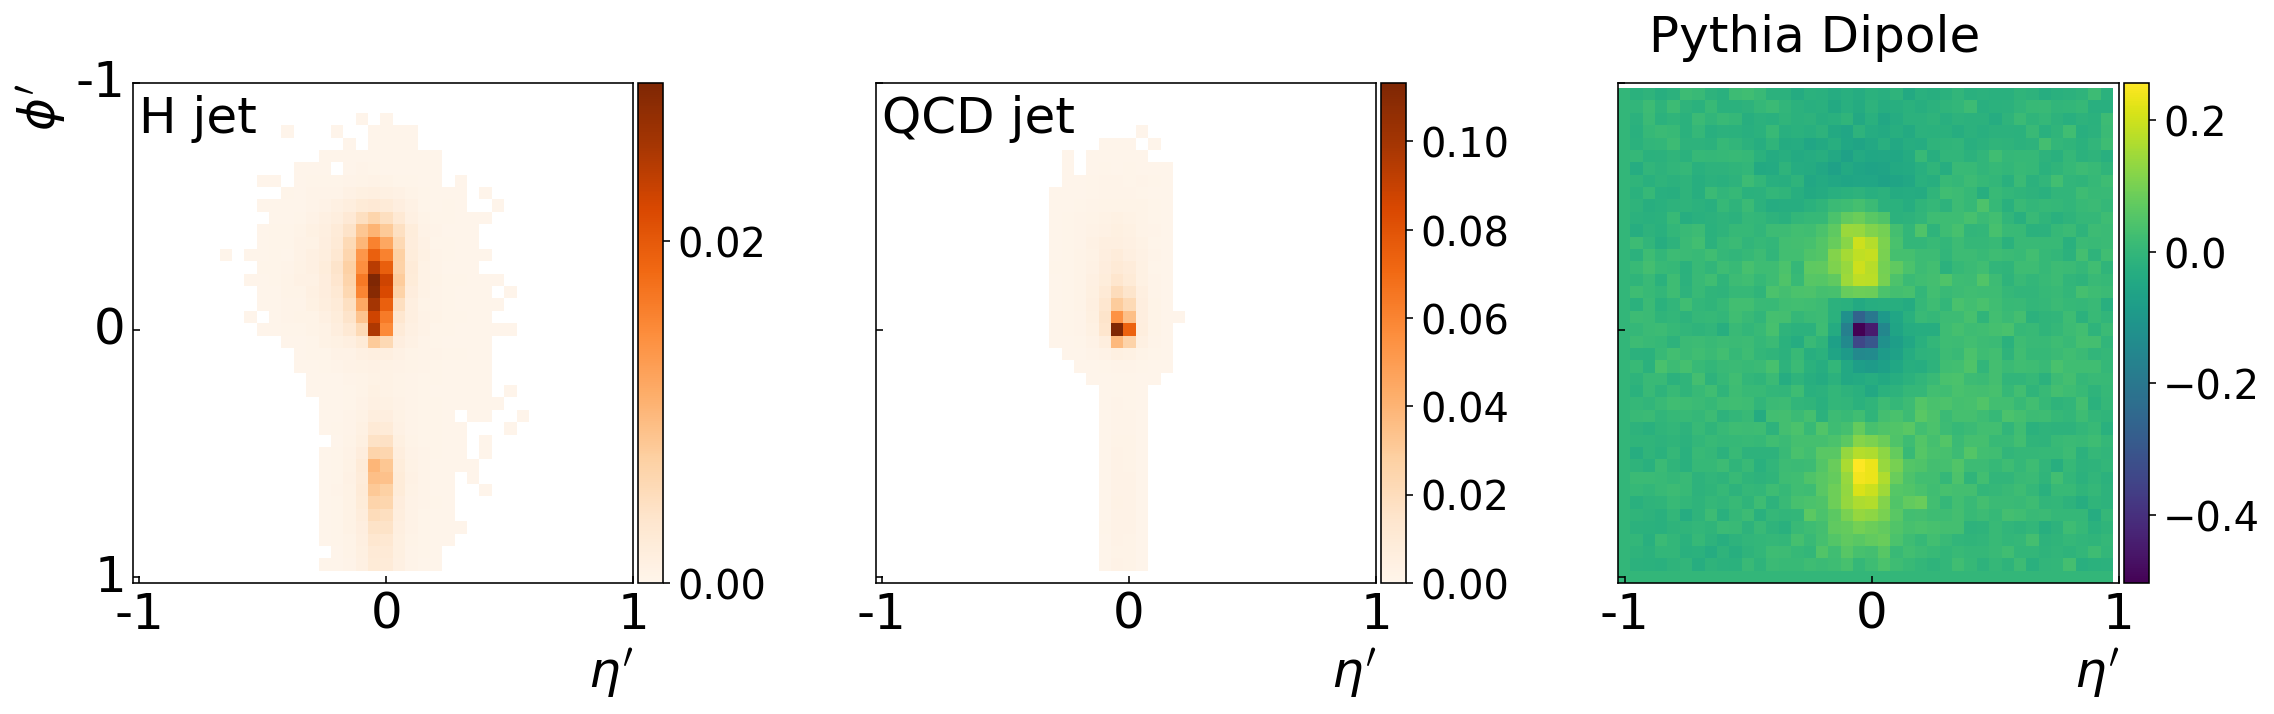

In [22]:
"""
Jet Images
"""

image_H = pythia_dip_H[:,0][:10000]
image_QCD = pythia_dip_QCD[:,0][:10000]


delta_jet = [
            image_H,image_QCD,(image_H-image_QCD)/(np.std(np.concatenate((image_H,image_QCD)), axis=0)+1e-5)
#             image_H,image_QCD, np.divide((image_H-image_QCD), (np.sqrt(variance_H+variance_QCD)+1e-5))
    
            ]

Name = [
                 "Herwig Angular", 
                 "Pythia Default",
                 "Pythia Vincia", 
                 "Pythia Dipole", 
#                  "Sherpa Default"
                ]

# mode_name = ["H jet", "QCD jet", "(H-QCD)/(std. dev)"]
mode_name = ["H jet", "QCD jet", "Pythia Dipole"]
# mode_name = ["Herwig Angular", "QCD jet", "(Herwig Angular-Pythia Default)/(std. dev)"]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 60))

for index, ax in enumerate(axes.flat):

    eventimage_average = np.average(delta_jet[index],axis=0)

    im = ax.imshow(eventimage_average,
                            vmin=0, 
#                           vmax=round(np.max(jetimage_average),3),
#                           vmax=0.08,
                          cmap=newcmap, 
                       origin='lower')
    if index == 2:
        im = ax.imshow(eventimage_average,
                       vmin=round(np.min(eventimage_average),3), 
                        vmax=round(np.max(eventimage_average),3),
                       cmap="viridis", 
                       origin='lower')
        
    ax.set_yticks([0,20,40])
    ax.set_yticklabels(["","",""], fontsize=25, rotation=0)
    ax.tick_params(axis='y', direction="in")
    
#     ax.set_xticks([0,20,40])
#     ax.set_xticklabels(["","",""], fontsize=25, rotation=0)
#     ax.tick_params(axis='x', direction="in")

    ax.set_xticks([0,20,40])
    ax.set_xticklabels(["-1","0","1"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
    ax.set_xlabel("$\eta'$", fontsize=25,horizontalalignment='right',x=1)
    ax.tick_params(axis='x', direction="in")
    
    if index == 0: 
        ax.set_yticks([0,20,40])
        # plot_axis.set_yticks([20,25,30])
        ax.set_yticklabels(["1","0","-1"], fontsize=25, rotation=0, verticalalignment='center', horizontalalignment="right")
        ax.set_ylabel("$\phi'$", fontsize=25, horizontalalignment='right',y=1)
#         ax.text(x=2, y=38, s="Pythia Default",c="k",fontsize=25)
        
        
    if index != 2:
        ax.text(x=0, y=36, s=str(mode_name[index]),fontsize=25)
#         ax.text(x=5, y=42.5, s=str(mode_name[index]),fontsize=25)
#         ax.text(x=2, y=38, s="p("+str(mode_name[index])+") > 0.9",fontsize=25)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad="1%")
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_ticks(np.arange(0, 1, 0.02))
    
    if index == 2:
        ax.text(x=2, y=42.5, s=str(mode_name[index]),fontsize=25)
#         ax.text(x=0, y=42.5, s=str(mode_name[index]),fontsize=15)
        
        
        
#     if index == 1:
#         ax.text(x=53, y=38, s="normalized to unity", fontsize=25, rotation=270)
        
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="1%")
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20)
# cbar.set_ticks(np.arange(-0.1, 0.12, 0.04))


plt.subplots_adjust(wspace=0.4, hspace=0.5)
# plt.savefig("./Plots/jet_image_VH_sub_ttH.pdf", transparent=True, bbox_inches='tight')
plt.show()